# Modelling using value of R0

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [467]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn import tree
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree

from sklearn.metrics import fbeta_score, make_scorer
import seaborn as sns
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
import shap

import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Read file and prepare data 

In [513]:
#df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL.csv')
del df['Unnamed: 0']
del df['deaths_prev_18']
del df['Excess mortality P-scores, all ages']
del df['Excess mortality P-scores, all ages Prev 18 days']
del df['Excess mortality P-scores, all ages Prev 36 days']
del df['deaths_prev_36']
del df['average_deaths_2015_2019_all_ages']
del df['deaths']
del df['month']
del df['life_expectancy']
del df['%df_population_gr_65']
del df['UN Population Division (Median Age) (2017)']
del df['number_of_arrivals']
del df['doctors_per_1000']
del df['nurses_per_1000']
del df['beds_per_1000']
#del df['residential']
#del df['urban_population']
#del df['%youth_unemployment_total']
#del df['income_support']
#del df['debt_relief']

In [514]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total', 'accumulated', 'R0_prev18', 'R0'],
      dtype='object')

In [515]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,income_support,Holiday,temp,prcp,urban_population,total_vaccinations_per_100,%youth_unemployment_total,accumulated,R0_prev18,R0
0,AUS,2020-03-08,1.050000,1.722333,-0.739000,4.977667,-2.089000,7.927667,2.0,1.0,...,0.0,0.0,23.571259,0.106900,85.904,NaN,11.84,0.000762,1.010084,0.985779
1,AUS,2020-03-15,0.761714,1.510143,-1.286000,7.697286,-0.819857,10.567714,2.0,1.0,...,0.0,0.0,22.446137,0.134501,85.904,NaN,11.84,0.001320,1.011711,1.000861
2,AUS,2020-03-22,1.285714,3.367429,-1.081714,9.346857,0.938857,10.877857,2.0,1.0,...,0.0,0.0,21.810602,0.160434,85.904,NaN,11.84,0.001926,1.004788,1.022493
3,AUS,2020-03-29,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,2.0,1.0,...,0.0,0.0,21.346512,0.142010,85.904,NaN,11.84,0.002502,0.985779,1.071272
4,AUS,2020-04-05,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,2.0,1.0,...,1.0,0.0,21.176835,0.054789,85.904,NaN,11.84,0.002969,1.000861,1.063946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.693857,-4.061286,10.183857,-36.040857,-19.755143,-28.101857,1.0,3.0,...,2.0,0.0,2.886531,0.052132,82.058,0.216667,8.30,0.179232,1.069347,0.968071
2038,USA,2021-01-17,-22.775429,-3.979571,12.653143,-38.877714,-16.653143,-42.081714,1.0,3.0,...,2.0,1.0,1.707192,0.066843,82.058,0.686667,8.30,0.188522,1.037051,0.949245
2039,USA,2021-01-24,-23.632714,-9.836714,14.061286,-41.020286,-15.857143,-41.714143,1.0,3.0,...,2.0,1.0,2.500769,0.094533,82.058,1.415000,8.30,0.198645,1.028931,0.894853
2040,USA,2021-01-31,-23.979714,-11.387857,11.449143,-39.571429,-22.591714,-28.999857,1.0,3.0,...,2.0,0.0,1.198128,0.038337,82.058,2.464000,8.30,0.206956,0.968071,0.910706


## Feature Engineering

df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)

df['movement']=df['number_of_arrivals']/((df['international_travel_controls']+df['restrictions_internal_movements'])/2)
del df['international_travel_controls']
del df['restrictions_internal_movements']
del df['number_of_arrivals']
df['tracking']=(df['testing_policy']+df['contact_tracing'])/2
del df['testing_policy']
del df['contact_tracing']
df['economic_support']=(df['debt_relief']+df['income_support'])/2
del df['debt_relief']
del df['income_support']
df['%youth_unemployment_total']=df['%youth_unemployment_total']*df['retail_and_recreation']
#df['days_from_beginning']= (pd.to_datetime(df['Date']) -pd.Timestamp(2020, 3, 1)).dt.days
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
df

date1=pd.Timestamp(2020, 4, 1)
df_R0=pd.DataFrame(df[(pd.to_datetime(df['Date']) < date1)].groupby('Code', as_index=False)['R0'].mean())
df_R0.columns=['Code','R0_mean']
df = pd.merge(df, df_R0, on=["Code"], how="left")
df['R0_mean_estimate']=df['R0_prev18']*df['R0_mean']
del df['R0_mean']
del df['R0_prev18']
df=df[[c for c in df if c not in ['R0']] 
       + ['R0']]
df

Text(0.5, 1.0, 'R0')

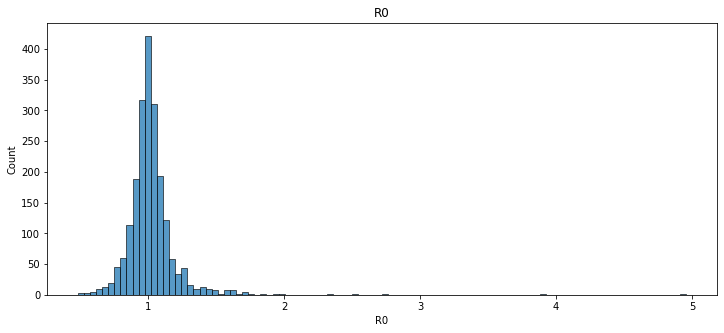

In [516]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes);
axes.set_title('R0')

In [464]:
df['R0'].describe()

count    2042.000000
mean        1.019757
std         0.192356
min         0.483971
25%         0.941328
50%         1.003552
75%         1.070626
max         4.959528
Name: R0, dtype: float64

# Modelling and Results

pip install xgboost

In [471]:
#Predictions from January 2021
#df=df[pd.to_datetime(df['Date']) > pd.Timestamp(2020, 5, 1)]
date1=pd.Timestamp(2021, 2, 1)

X_1=df[(pd.to_datetime(df['Date']) <= date1)]
X_2=df[(pd.to_datetime(df['Date']) > date1)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['R0']
y_test=X_2['R0']

In [472]:
X_train

,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,international_travel_controls,restrictions_internal_movements,...,income_support,Holiday,temp,prcp,urban_population,total_vaccinations_per_100,%youth_unemployment_total,%df_population_gr_65,accumulated,R0_prev18
0,1.050000,1.722333,-0.739000,4.977667,-2.089000,7.927667,2.0,1.0,3.0,0.0,...,0.0,0.0,23.571259,0.106900,85.904,NaN,11.84,15.921202,0.000762,1.010084
1,0.761714,1.510143,-1.286000,7.697286,-0.819857,10.567714,2.0,1.0,3.0,0.0,...,0.0,0.0,22.446137,0.134501,85.904,NaN,11.84,15.921202,0.001320,1.011711
2,1.285714,3.367429,-1.081714,9.346857,0.938857,10.877857,2.0,1.0,3.0,0.0,...,0.0,0.0,21.810602,0.160434,85.904,NaN,11.84,15.921202,0.001926,1.004788
3,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,2.0,1.0,3.0,0.0,...,0.0,0.0,21.346512,0.142010,85.904,NaN,11.84,15.921202,0.002502,0.985779
4,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,2.0,1.0,3.0,0.0,...,1.0,0.0,21.176835,0.054789,85.904,NaN,11.84,15.921202,0.002969,1.000861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,-19.897857,-7.326429,9.693571,-37.489714,-15.469429,-26.387857,1.0,3.0,3.0,2.0,...,2.0,0.0,2.770087,0.052050,82.058,NaN,8.30,16.209606,0.169901,1.082737
2037,-17.693857,-4.061286,10.183857,-36.040857,-19.755143,-28.101857,1.0,3.0,3.0,2.0,...,2.0,0.0,2.886531,0.052132,82.058,0.216667,8.30,16.209606,0.179232,1.069347
2038,-22.775429,-3.979571,12.653143,-38.877714,-16.653143,-42.081714,1.0,3.0,3.0,2.0,...,2.0,1.0,1.707192,0.066843,82.058,0.686667,8.30,16.209606,0.188522,1.037051
2039,-23.632714,-9.836714,14.061286,-41.020286,-15.857143,-41.714143,1.0,3.0,3.0,2.0,...,2.0,1.0,2.500769,0.094533,82.058,1.415000,8.30,16.209606,0.198645,1.028931


## XGBoost Regressor 

### Modelling with GridSearchCV 

In [308]:
#Mape custom scoring function
def mape_fun(pred, train): 
    return np.mean(np.abs((pred - train) / train)) * 100

In [271]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,5)],  'subsample':[i/10.0 for i in range(8,11)],
'colsample_bytree':[i/10.0 for i in range(8,11)], 'max_depth': [6,7,8]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(num_boost_rounds=1000) 

grid = GridSearchCV(xgb, params, verbose=1, n_jobs=-1, scoring=make_scorer(mape_fun))

In [272]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.1min finished


[01:03:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 5.24 s, sys: 337 ms, total: 5.58 s
Wall time: 2min 5s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
   

In [273]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_boost_rounds=1000,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [274]:
y_pred=grid.best_estimator_.predict(X_test)
y_pred_train=grid.best_estimator_.predict(X_train)

### XGB Evaluation

#### Test Set

In [275]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.11741342028518048
mse score is 0.023476600404477004
rmse score is 0.15322075709406022
r2 score is -0.17489191769082324
mape score is 12.99437430628613


#### Train Set

In [276]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.07151594272807975
mse score is 0.010500599214598637
rmse score is 0.10247243148573491
r2 score is 0.730734810803103
mape score is 6.845221515922946


In [277]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
47,0.908056,0.980501,0.072446
48,1.051824,1.113843,0.062019
49,1.093401,1.142472,0.049072
89,0.748574,0.945808,0.197234
90,0.790592,0.993271,0.202678
...,...,...,...
2037,0.968071,0.925667,0.042404
2038,0.949245,0.907945,0.041300
2039,0.894853,0.907945,0.013091
2040,0.910706,0.934292,0.023586


## Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

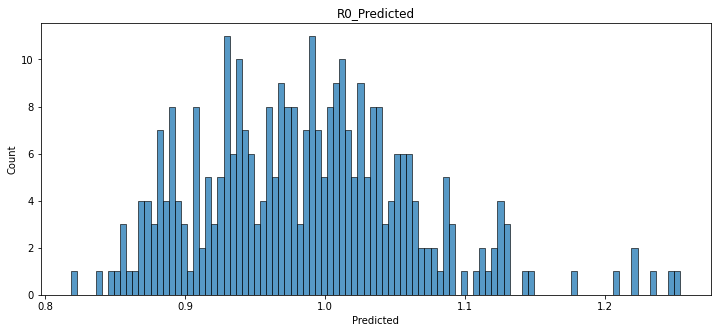

In [278]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

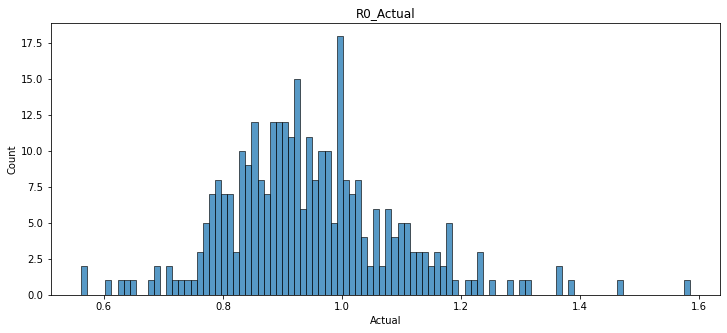

In [279]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

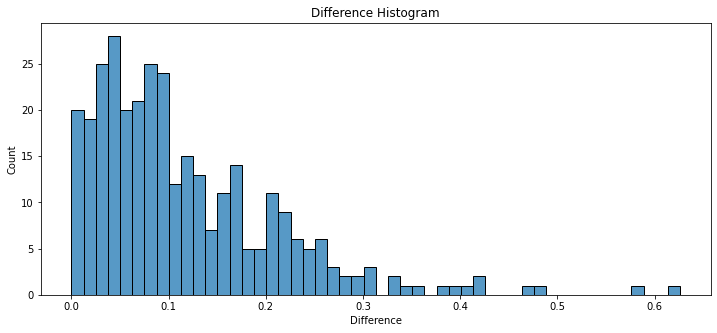

In [280]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

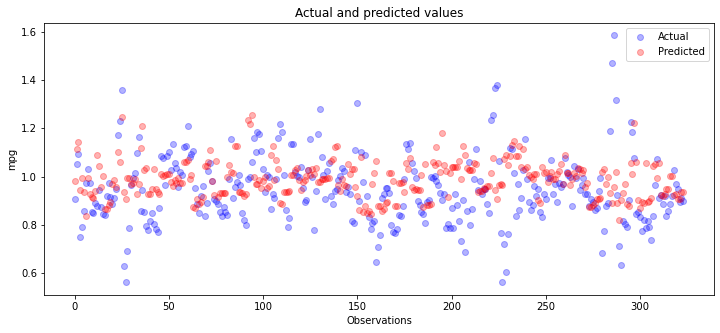

In [281]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

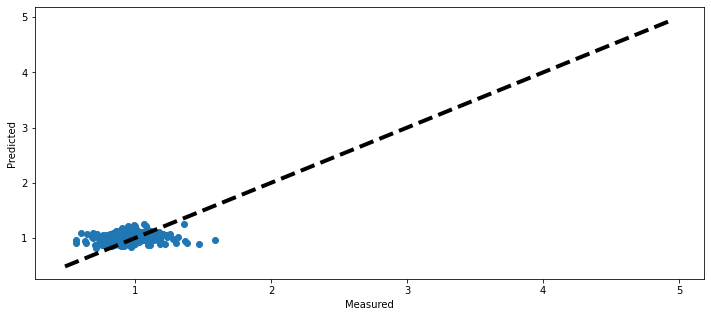

In [282]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

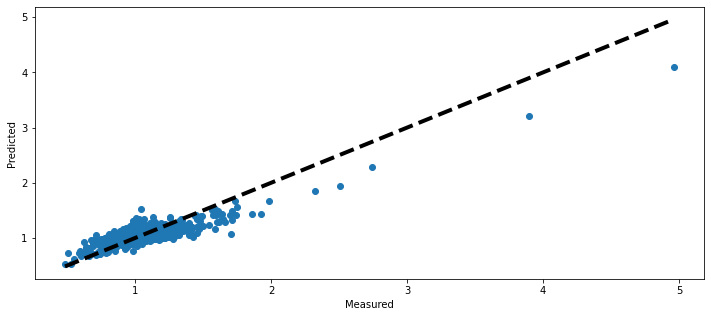

In [283]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

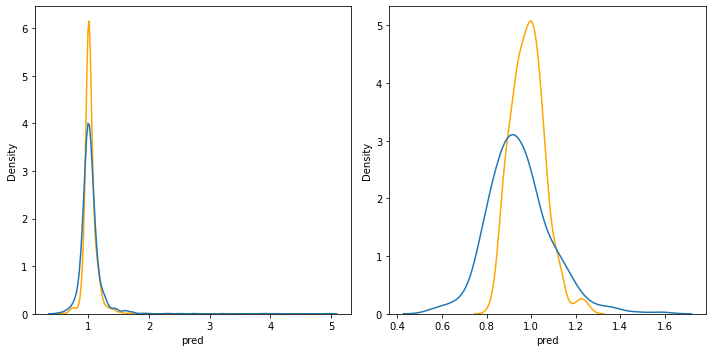

In [284]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [812]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1746,0.837500,1.584312,-0.75,0.75,-47.14
1880,0.781149,1.457326,-0.68,0.68,-46.40
1680,0.950991,1.629880,-0.68,0.68,-41.65
1902,0.847221,1.450802,-0.60,0.60,-41.60
1679,0.944587,1.598500,-0.65,0.65,-40.91
...,...,...,...,...,...
1780,1.438556,0.960546,0.48,0.48,49.76
1685,1.183061,0.788807,0.39,0.39,49.98
1606,1.607977,1.029392,0.58,0.58,56.21
1890,1.296070,0.774448,0.52,0.52,67.35


## Feature importance 

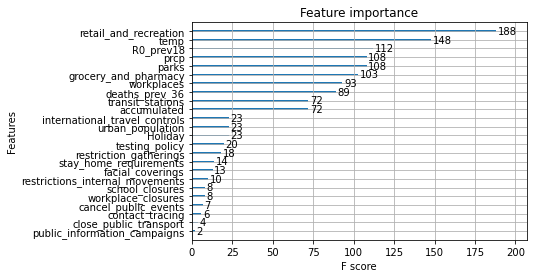

In [813]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

## Light GBM

### Modelling 

In [587]:
params = {
    'metric': ['mae'],
    "max_depth":[9,10,11] ,
    "num_leaves": [10,20,30],  
    "max_bin": [50,75,100],
}

# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid = GridSearchCV(lgbm, params)

In [588]:
%%time
grid.fit(X_train, y_train)

CPU times: user 50 s, sys: 1.44 s, total: 51.5 s
Wall time: 17.4 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_bin': [50, 75, 100], 'max_depth': [9, 10, 11],
                         'metric': ['mae'], 'num_leaves': [10, 20, 30]})

In [589]:
grid.best_estimator_

LGBMRegressor(max_bin=75, max_depth=10, metric='mae', num_leaves=30)

In [590]:
y_pred = grid.best_estimator_.predict(X_test)
y_pred_train = grid.best_estimator_.predict(X_train)

### Evaluation

#### Test Set

In [591]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse':rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.12398817223149244
mse score is 0.030415192637765015
rmse score is 0.17439952017641852
r2 score is -1.3961329551108643
mape score is 13.947074219874045


#### Train Set

In [592]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.04497109552178795
mse score is 0.007404238774756438
rmse score is 0.08604788652114843
r2 score is 0.8061692940481964
mape score is 4.2661869113660185


In [593]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
47,0.908056,1.131077,0.223021
48,1.051824,1.142734,0.090910
49,1.093401,1.180124,0.086723
94,0.972591,0.883818,0.088773
95,0.851891,0.889294,0.037403
...,...,...,...
1946,0.837391,0.913734,0.076343
1947,0.856123,0.990883,0.134760
1948,0.886491,0.986412,0.099921
1949,0.917596,0.994284,0.076688


## Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

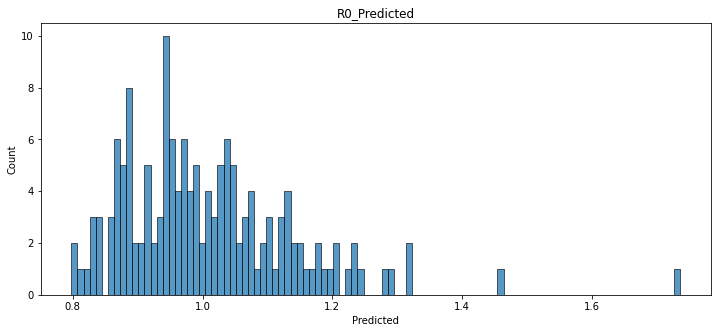

In [594]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

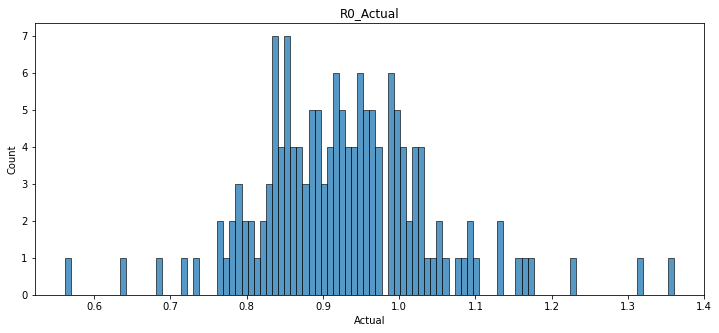

In [595]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

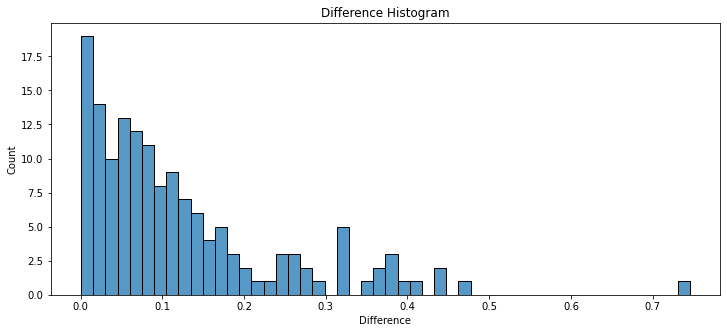

In [596]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

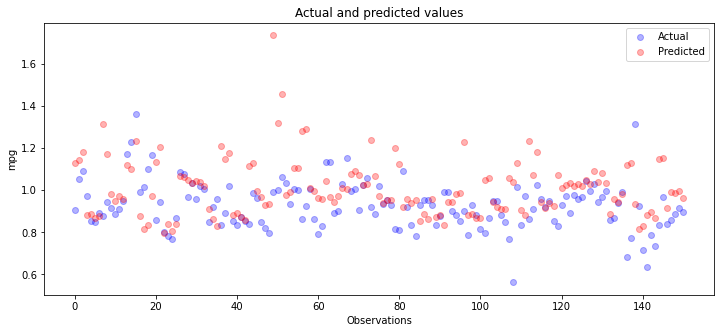

In [597]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

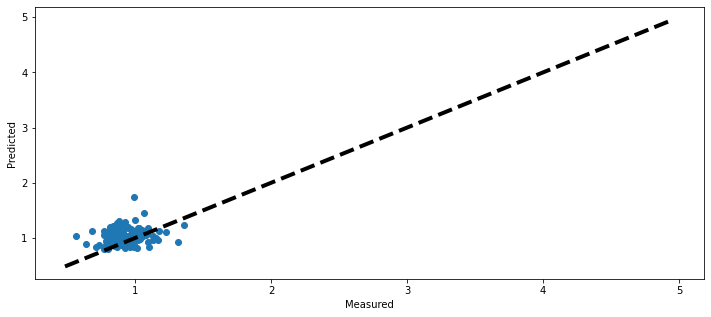

In [598]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

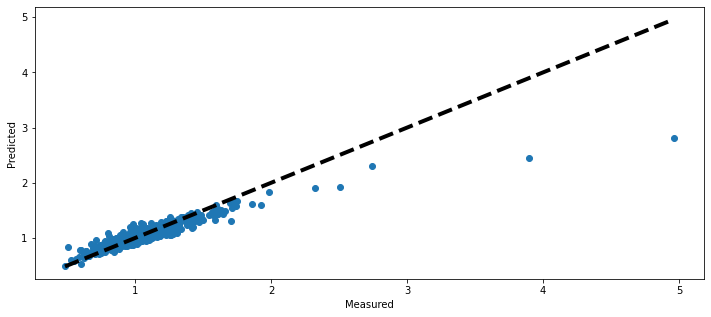

In [599]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

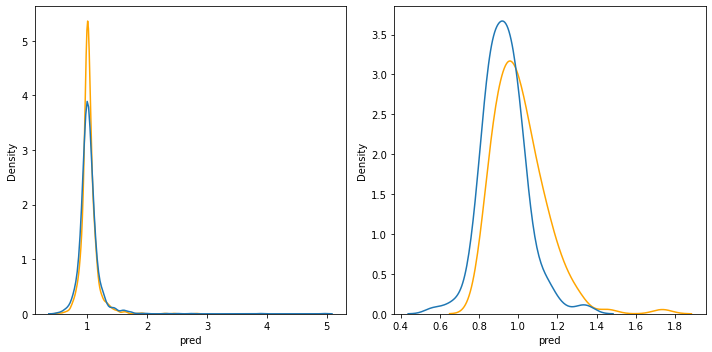

In [600]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [601]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1747,0.934551,1.314996,-0.38,0.38,-28.93
205,0.835322,1.098982,-0.26,0.26,-23.99
204,0.817711,1.016687,-0.20,0.20,-19.57
206,0.970851,1.165536,-0.19,0.19,-16.70
883,0.917970,1.090737,-0.17,0.17,-15.84
...,...,...,...,...,...
622,1.279786,0.864701,0.42,0.42,48.00
102,1.314304,0.879219,0.44,0.44,49.49
1701,1.121733,0.681949,0.44,0.44,64.49
567,1.736254,0.990901,0.75,0.75,75.22


In [602]:
res_df_test['pred'].describe()

count    151.000000
mean       1.008450
std        0.135211
min        0.797841
25%        0.912868
50%        0.984260
75%        1.072945
max        1.736254
Name: pred, dtype: float64

In [603]:
res_df_test['test'].describe()

count    151.000000
mean       0.928211
std        0.113040
min        0.561646
25%        0.854181
50%        0.925324
75%        0.992006
max        1.360156
Name: test, dtype: float64

In [606]:
df.iloc[204]

Code                                      BGR
Date                               2021-02-14
retail_and_recreation                 -45.408
grocery_and_pharmacy                 -7.95914
residential                           6.12229
transit_stations                     -24.6326
parks                                -11.3877
workplaces                           -27.5919
contact_tracing                             2
testing_policy                              1
international_travel_controls               3
restrictions_internal_movements             0
close_public_transport                      0
public_information_campaigns                2
facial_coverings                            3
stay_home_requirements                      0
restriction_gatherings                      3
cancel_public_events                        2
workplace_closures                          2
school_closures                             2
debt_relief                                 1
income_support                    

## CatBoost Regressor 

### Modelling 

In [554]:
ctbst = CatBoostRegressor(learning_rate=0.02, eval_metric='MAPE',depth=10, has_time=True)

ctbst.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)

0:	learn: 0.0908635	test: 0.1212120	best: 0.1212120 (0)	total: 49ms	remaining: 49s
1:	learn: 0.0905481	test: 0.1208189	best: 0.1208189 (1)	total: 96.7ms	remaining: 48.3s
2:	learn: 0.0903207	test: 0.1200478	best: 0.1200478 (2)	total: 165ms	remaining: 54.8s
3:	learn: 0.0899952	test: 0.1195138	best: 0.1195138 (3)	total: 202ms	remaining: 50.2s
4:	learn: 0.0897157	test: 0.1189087	best: 0.1189087 (4)	total: 236ms	remaining: 47s
5:	learn: 0.0895354	test: 0.1183047	best: 0.1183047 (5)	total: 287ms	remaining: 47.5s
6:	learn: 0.0893150	test: 0.1179860	best: 0.1179860 (6)	total: 334ms	remaining: 47.4s
7:	learn: 0.0891197	test: 0.1173240	best: 0.1173240 (7)	total: 370ms	remaining: 45.9s
8:	learn: 0.0888136	test: 0.1168535	best: 0.1168535 (8)	total: 404ms	remaining: 44.4s
9:	learn: 0.0885496	test: 0.1164253	best: 0.1164253 (9)	total: 436ms	remaining: 43.2s
10:	learn: 0.0882701	test: 0.1158613	best: 0.1158613 (10)	total: 470ms	remaining: 42.3s
11:	learn: 0.0880206	test: 0.1154898	best: 0.1154898 (11

96:	learn: 0.0744525	test: 0.0946845	best: 0.0946845 (96)	total: 4.52s	remaining: 42.1s
97:	learn: 0.0743556	test: 0.0946233	best: 0.0946233 (97)	total: 4.57s	remaining: 42.1s
98:	learn: 0.0742110	test: 0.0943397	best: 0.0943397 (98)	total: 4.62s	remaining: 42s
99:	learn: 0.0741355	test: 0.0942065	best: 0.0942065 (99)	total: 4.65s	remaining: 41.9s
100:	learn: 0.0740533	test: 0.0941955	best: 0.0941955 (100)	total: 4.68s	remaining: 41.7s
101:	learn: 0.0739116	test: 0.0943462	best: 0.0941955 (100)	total: 4.71s	remaining: 41.5s
102:	learn: 0.0737846	test: 0.0942621	best: 0.0941955 (100)	total: 4.77s	remaining: 41.5s
103:	learn: 0.0736083	test: 0.0941643	best: 0.0941643 (103)	total: 4.82s	remaining: 41.6s
104:	learn: 0.0734520	test: 0.0941508	best: 0.0941508 (104)	total: 4.87s	remaining: 41.5s
105:	learn: 0.0734210	test: 0.0941649	best: 0.0941508 (104)	total: 4.91s	remaining: 41.4s
106:	learn: 0.0733136	test: 0.0939574	best: 0.0939574 (106)	total: 4.95s	remaining: 41.3s
107:	learn: 0.073157

189:	learn: 0.0646458	test: 0.0891389	best: 0.0890567 (186)	total: 9.43s	remaining: 40.2s
190:	learn: 0.0645471	test: 0.0889939	best: 0.0889939 (190)	total: 9.48s	remaining: 40.2s
191:	learn: 0.0643879	test: 0.0887995	best: 0.0887995 (191)	total: 9.52s	remaining: 40s
192:	learn: 0.0643329	test: 0.0887682	best: 0.0887682 (192)	total: 9.55s	remaining: 40s
193:	learn: 0.0642958	test: 0.0887769	best: 0.0887682 (192)	total: 9.6s	remaining: 39.9s
194:	learn: 0.0642181	test: 0.0887630	best: 0.0887630 (194)	total: 9.63s	remaining: 39.8s
195:	learn: 0.0641203	test: 0.0887539	best: 0.0887539 (195)	total: 9.68s	remaining: 39.7s
196:	learn: 0.0640024	test: 0.0886810	best: 0.0886810 (196)	total: 9.71s	remaining: 39.6s
197:	learn: 0.0639470	test: 0.0886835	best: 0.0886810 (196)	total: 9.75s	remaining: 39.5s
198:	learn: 0.0637769	test: 0.0886726	best: 0.0886726 (198)	total: 9.79s	remaining: 39.4s
199:	learn: 0.0636882	test: 0.0886484	best: 0.0886484 (199)	total: 9.84s	remaining: 39.4s
200:	learn: 0.0

284:	learn: 0.0567589	test: 0.0884749	best: 0.0878605 (214)	total: 14.5s	remaining: 36.3s
285:	learn: 0.0566818	test: 0.0884567	best: 0.0878605 (214)	total: 14.6s	remaining: 36.3s
286:	learn: 0.0566265	test: 0.0885121	best: 0.0878605 (214)	total: 14.6s	remaining: 36.3s
287:	learn: 0.0565575	test: 0.0885277	best: 0.0878605 (214)	total: 14.7s	remaining: 36.2s
288:	learn: 0.0565074	test: 0.0885002	best: 0.0878605 (214)	total: 14.7s	remaining: 36.2s
289:	learn: 0.0564136	test: 0.0884770	best: 0.0878605 (214)	total: 14.8s	remaining: 36.2s
290:	learn: 0.0563642	test: 0.0884229	best: 0.0878605 (214)	total: 14.8s	remaining: 36.1s
291:	learn: 0.0563175	test: 0.0884121	best: 0.0878605 (214)	total: 14.9s	remaining: 36.1s
292:	learn: 0.0563028	test: 0.0884027	best: 0.0878605 (214)	total: 14.9s	remaining: 35.9s
293:	learn: 0.0562438	test: 0.0883784	best: 0.0878605 (214)	total: 14.9s	remaining: 35.9s
294:	learn: 0.0561430	test: 0.0883231	best: 0.0878605 (214)	total: 15s	remaining: 35.9s
295:	learn: 

377:	learn: 0.0505762	test: 0.0896158	best: 0.0878605 (214)	total: 18.5s	remaining: 30.5s
378:	learn: 0.0504929	test: 0.0896249	best: 0.0878605 (214)	total: 18.6s	remaining: 30.4s
379:	learn: 0.0504062	test: 0.0897322	best: 0.0878605 (214)	total: 18.6s	remaining: 30.3s
380:	learn: 0.0503635	test: 0.0897559	best: 0.0878605 (214)	total: 18.6s	remaining: 30.3s
381:	learn: 0.0502917	test: 0.0897569	best: 0.0878605 (214)	total: 18.7s	remaining: 30.2s
382:	learn: 0.0502110	test: 0.0897598	best: 0.0878605 (214)	total: 18.7s	remaining: 30.1s
383:	learn: 0.0501850	test: 0.0897926	best: 0.0878605 (214)	total: 18.7s	remaining: 30s
384:	learn: 0.0501382	test: 0.0897627	best: 0.0878605 (214)	total: 18.8s	remaining: 30s
385:	learn: 0.0500301	test: 0.0897472	best: 0.0878605 (214)	total: 18.8s	remaining: 29.9s
386:	learn: 0.0499391	test: 0.0897300	best: 0.0878605 (214)	total: 18.8s	remaining: 29.8s
387:	learn: 0.0499019	test: 0.0897806	best: 0.0878605 (214)	total: 18.9s	remaining: 29.8s
388:	learn: 0.

469:	learn: 0.0453753	test: 0.0912136	best: 0.0878605 (214)	total: 22.4s	remaining: 25.3s
470:	learn: 0.0452978	test: 0.0912280	best: 0.0878605 (214)	total: 22.5s	remaining: 25.3s
471:	learn: 0.0452302	test: 0.0912781	best: 0.0878605 (214)	total: 22.5s	remaining: 25.2s
472:	learn: 0.0451406	test: 0.0913019	best: 0.0878605 (214)	total: 22.6s	remaining: 25.1s
473:	learn: 0.0450893	test: 0.0913312	best: 0.0878605 (214)	total: 22.6s	remaining: 25.1s
474:	learn: 0.0450684	test: 0.0913632	best: 0.0878605 (214)	total: 22.7s	remaining: 25.1s
475:	learn: 0.0450332	test: 0.0913634	best: 0.0878605 (214)	total: 22.7s	remaining: 25s
476:	learn: 0.0449478	test: 0.0913335	best: 0.0878605 (214)	total: 22.8s	remaining: 24.9s
477:	learn: 0.0448987	test: 0.0913386	best: 0.0878605 (214)	total: 22.8s	remaining: 24.9s
478:	learn: 0.0448177	test: 0.0913787	best: 0.0878605 (214)	total: 22.8s	remaining: 24.8s
479:	learn: 0.0447882	test: 0.0913965	best: 0.0878605 (214)	total: 22.9s	remaining: 24.8s
480:	learn: 

562:	learn: 0.0412172	test: 0.0932751	best: 0.0878605 (214)	total: 26.8s	remaining: 20.8s
563:	learn: 0.0411693	test: 0.0932703	best: 0.0878605 (214)	total: 26.8s	remaining: 20.8s
564:	learn: 0.0411514	test: 0.0932909	best: 0.0878605 (214)	total: 26.9s	remaining: 20.7s
565:	learn: 0.0411205	test: 0.0932831	best: 0.0878605 (214)	total: 26.9s	remaining: 20.6s
566:	learn: 0.0411038	test: 0.0932922	best: 0.0878605 (214)	total: 26.9s	remaining: 20.6s
567:	learn: 0.0410480	test: 0.0933488	best: 0.0878605 (214)	total: 27s	remaining: 20.5s
568:	learn: 0.0410201	test: 0.0933592	best: 0.0878605 (214)	total: 27s	remaining: 20.5s
569:	learn: 0.0409857	test: 0.0933656	best: 0.0878605 (214)	total: 27.1s	remaining: 20.4s
570:	learn: 0.0409544	test: 0.0933784	best: 0.0878605 (214)	total: 27.1s	remaining: 20.4s
571:	learn: 0.0409213	test: 0.0934300	best: 0.0878605 (214)	total: 27.2s	remaining: 20.3s
572:	learn: 0.0408648	test: 0.0933835	best: 0.0878605 (214)	total: 27.2s	remaining: 20.3s
573:	learn: 0.

657:	learn: 0.0375240	test: 0.0945649	best: 0.0878605 (214)	total: 31.5s	remaining: 16.4s
658:	learn: 0.0375029	test: 0.0945880	best: 0.0878605 (214)	total: 31.5s	remaining: 16.3s
659:	learn: 0.0374854	test: 0.0946022	best: 0.0878605 (214)	total: 31.6s	remaining: 16.3s
660:	learn: 0.0374578	test: 0.0946296	best: 0.0878605 (214)	total: 31.6s	remaining: 16.2s
661:	learn: 0.0374101	test: 0.0946075	best: 0.0878605 (214)	total: 31.7s	remaining: 16.2s
662:	learn: 0.0373830	test: 0.0946424	best: 0.0878605 (214)	total: 31.8s	remaining: 16.1s
663:	learn: 0.0373741	test: 0.0946442	best: 0.0878605 (214)	total: 31.8s	remaining: 16.1s
664:	learn: 0.0373609	test: 0.0946634	best: 0.0878605 (214)	total: 31.8s	remaining: 16s
665:	learn: 0.0373138	test: 0.0946884	best: 0.0878605 (214)	total: 31.9s	remaining: 16s
666:	learn: 0.0372781	test: 0.0947275	best: 0.0878605 (214)	total: 31.9s	remaining: 15.9s
667:	learn: 0.0372240	test: 0.0947139	best: 0.0878605 (214)	total: 31.9s	remaining: 15.9s
668:	learn: 0.

752:	learn: 0.0343496	test: 0.0959001	best: 0.0878605 (214)	total: 36.3s	remaining: 11.9s
753:	learn: 0.0343016	test: 0.0958963	best: 0.0878605 (214)	total: 36.3s	remaining: 11.8s
754:	learn: 0.0342927	test: 0.0959024	best: 0.0878605 (214)	total: 36.3s	remaining: 11.8s
755:	learn: 0.0342664	test: 0.0959315	best: 0.0878605 (214)	total: 36.4s	remaining: 11.7s
756:	learn: 0.0342391	test: 0.0959358	best: 0.0878605 (214)	total: 36.4s	remaining: 11.7s
757:	learn: 0.0341836	test: 0.0959236	best: 0.0878605 (214)	total: 36.5s	remaining: 11.7s
758:	learn: 0.0341415	test: 0.0959186	best: 0.0878605 (214)	total: 36.5s	remaining: 11.6s
759:	learn: 0.0341018	test: 0.0959480	best: 0.0878605 (214)	total: 36.6s	remaining: 11.6s
760:	learn: 0.0340706	test: 0.0960259	best: 0.0878605 (214)	total: 36.6s	remaining: 11.5s
761:	learn: 0.0340392	test: 0.0960138	best: 0.0878605 (214)	total: 36.7s	remaining: 11.4s
762:	learn: 0.0340235	test: 0.0960491	best: 0.0878605 (214)	total: 36.7s	remaining: 11.4s
763:	learn

844:	learn: 0.0314713	test: 0.0966660	best: 0.0878605 (214)	total: 41s	remaining: 7.51s
845:	learn: 0.0314262	test: 0.0967112	best: 0.0878605 (214)	total: 41s	remaining: 7.46s
846:	learn: 0.0313901	test: 0.0967192	best: 0.0878605 (214)	total: 41.1s	remaining: 7.42s
847:	learn: 0.0313515	test: 0.0967411	best: 0.0878605 (214)	total: 41.1s	remaining: 7.37s
848:	learn: 0.0313204	test: 0.0967805	best: 0.0878605 (214)	total: 41.2s	remaining: 7.32s
849:	learn: 0.0312941	test: 0.0968378	best: 0.0878605 (214)	total: 41.3s	remaining: 7.28s
850:	learn: 0.0312813	test: 0.0968493	best: 0.0878605 (214)	total: 41.3s	remaining: 7.24s
851:	learn: 0.0312625	test: 0.0968615	best: 0.0878605 (214)	total: 41.4s	remaining: 7.19s
852:	learn: 0.0312425	test: 0.0968798	best: 0.0878605 (214)	total: 41.4s	remaining: 7.14s
853:	learn: 0.0312278	test: 0.0968673	best: 0.0878605 (214)	total: 41.5s	remaining: 7.09s
854:	learn: 0.0312003	test: 0.0968666	best: 0.0878605 (214)	total: 41.5s	remaining: 7.04s
855:	learn: 0.

939:	learn: 0.0291836	test: 0.0974930	best: 0.0878605 (214)	total: 45.8s	remaining: 2.92s
940:	learn: 0.0291541	test: 0.0975053	best: 0.0878605 (214)	total: 45.8s	remaining: 2.87s
941:	learn: 0.0291082	test: 0.0975308	best: 0.0878605 (214)	total: 45.9s	remaining: 2.83s
942:	learn: 0.0290845	test: 0.0975277	best: 0.0878605 (214)	total: 45.9s	remaining: 2.78s
943:	learn: 0.0290603	test: 0.0975289	best: 0.0878605 (214)	total: 46s	remaining: 2.73s
944:	learn: 0.0290294	test: 0.0975459	best: 0.0878605 (214)	total: 46.1s	remaining: 2.68s
945:	learn: 0.0290097	test: 0.0975414	best: 0.0878605 (214)	total: 46.1s	remaining: 2.63s
946:	learn: 0.0289828	test: 0.0975389	best: 0.0878605 (214)	total: 46.2s	remaining: 2.58s
947:	learn: 0.0289548	test: 0.0975060	best: 0.0878605 (214)	total: 46.2s	remaining: 2.54s
948:	learn: 0.0289477	test: 0.0975024	best: 0.0878605 (214)	total: 46.3s	remaining: 2.49s
949:	learn: 0.0289376	test: 0.0975073	best: 0.0878605 (214)	total: 46.3s	remaining: 2.44s
950:	learn: 

In [572]:
y_pred = ctbst.predict(X_test)
y_pred_train = ctbst.predict(X_train)

### Evaluation

#### Test Set

In [573]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.08997363288946617
mse score is 0.01396735638328823
rmse score is 0.1181835706995191
r2 score is -0.10035939355583534
mape score is 10.368974833932754


#### Train Set

In [574]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.07085225352408069
mse score is 0.01260693880974904
rmse score is 0.11228062526433062
r2 score is 0.6699712254396835
mape score is 6.779556994856476


In [575]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
47,0.908056,1.010430,0.102375
48,1.051824,1.020808,0.031016
49,1.093401,1.033766,0.059635
94,0.972591,0.907099,0.065492
95,0.851891,0.917388,0.065496
...,...,...,...
1946,0.837391,0.960885,0.123495
1947,0.856123,0.968156,0.112033
1948,0.886491,0.982737,0.096246
1949,0.917596,0.990307,0.072711


### Results View

### Predicted vs Actual R0 Distribution

#### Predicted 

Text(0.5, 1.0, 'R0_Predicted')

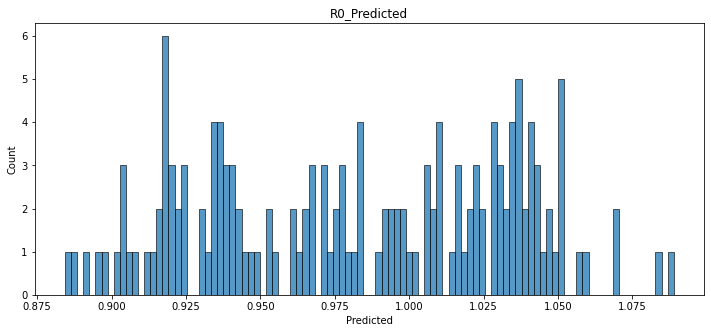

In [576]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

#### Actual 

Text(0.5, 1.0, 'R0_Actual')

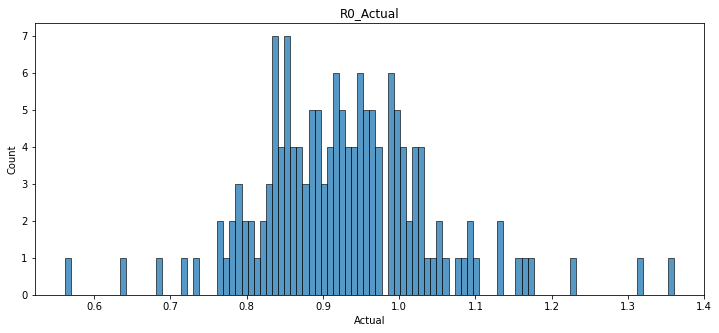

In [577]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

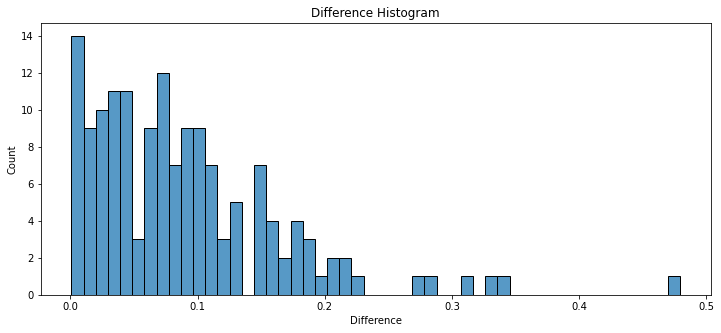

In [578]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

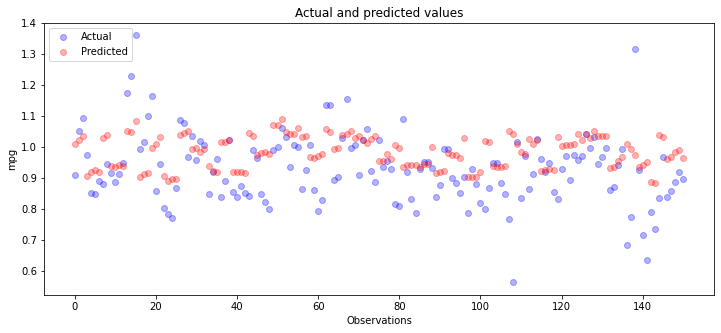

In [579]:
_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

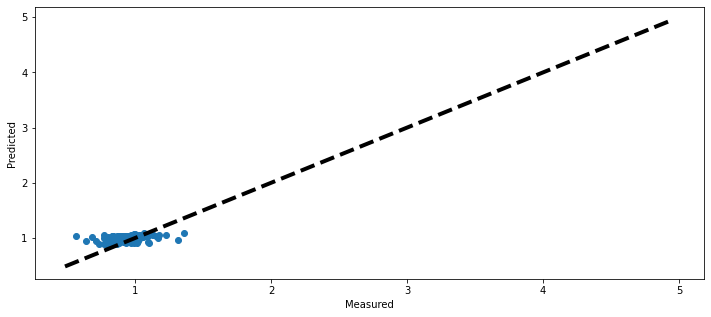

In [580]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

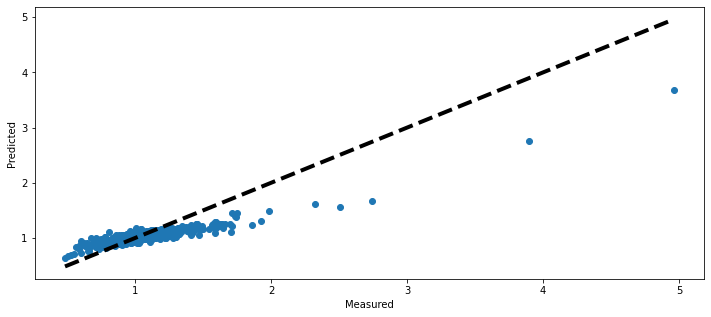

In [581]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

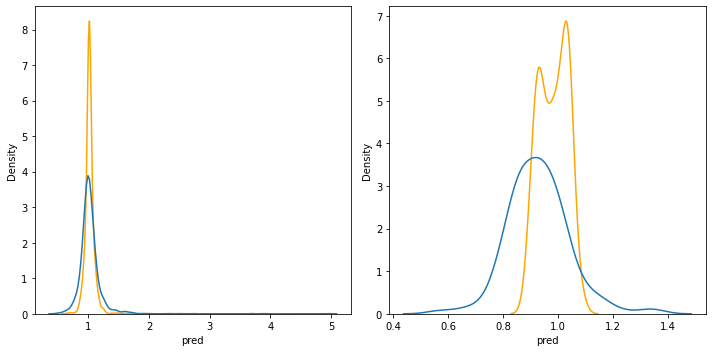

In [582]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [583]:
res_df_test

,pred,test,dif,dif_abs,dif%
47,1.010430,0.908056,0.10,0.10,11.27
48,1.020808,1.051824,-0.03,0.03,-2.95
49,1.033766,1.093401,-0.06,0.06,-5.45
94,0.907099,0.972591,-0.07,0.07,-6.73
95,0.917388,0.851891,0.07,0.07,7.69
...,...,...,...,...,...
1946,0.960885,0.837391,0.12,0.12,14.75
1947,0.968156,0.856123,0.11,0.11,13.09
1948,0.982737,0.886491,0.10,0.10,10.86
1949,0.990307,0.917596,0.07,0.07,7.92


In [584]:
res_df_test['pred'].describe()

count    151.000000
mean       0.982798
std        0.051113
min        0.884351
25%        0.936226
50%        0.983498
75%        1.029821
max        1.088863
Name: pred, dtype: float64

In [585]:
np.abs(res_df_test['dif%']).mean()

10.368543046357617

ValueError: shape mismatch: objects cannot be broadcast to a single shape

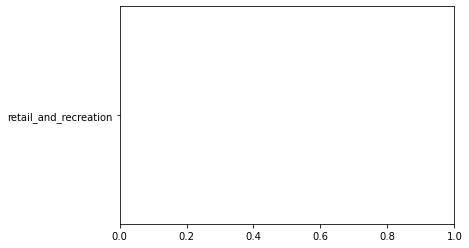

In [586]:
sorted_feature_importance = ctbst.feature_importances_.argsort()
plt.barh(df[df.columns[2:-1]].columns, 
        ctbst.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

IndexError: index 28 is out of bounds for axis 0 with size 28

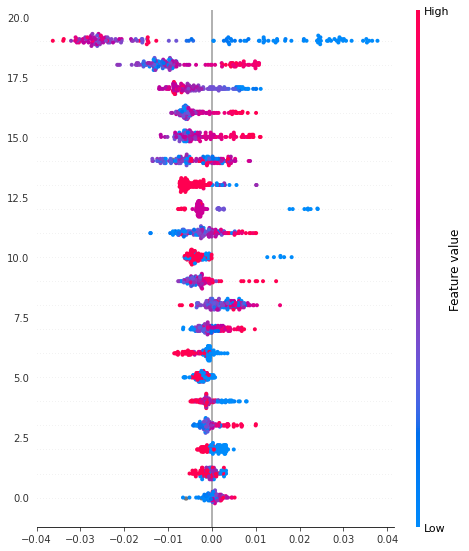

In [571]:
explainer = shap.TreeExplainer(ctbst)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = df[df.columns[2:-1]].columns)

## Cross Validation

In [371]:
aux=df.copy()
aux=aux.sort_values('Date')
X=aux[aux.columns[2:-1]]
y=aux[aux.columns[-1]]

In [372]:
k = 4
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    ctbst.fit(X_train, y_train)
    pred_values = ctbst.predict(X_test)
     
    acc = np.mean(np.abs((y_test - pred_values) / y_test)) * 100
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

0:	learn: 0.0928692	total: 17.8ms	remaining: 17.8s
1:	learn: 0.0927808	total: 33ms	remaining: 16.5s
2:	learn: 0.0926898	total: 49.9ms	remaining: 16.6s
3:	learn: 0.0926690	total: 61.2ms	remaining: 15.2s
4:	learn: 0.0926096	total: 83.7ms	remaining: 16.7s
5:	learn: 0.0925672	total: 92.7ms	remaining: 15.4s
6:	learn: 0.0925076	total: 101ms	remaining: 14.4s
7:	learn: 0.0924402	total: 111ms	remaining: 13.7s
8:	learn: 0.0923983	total: 119ms	remaining: 13.1s
9:	learn: 0.0923206	total: 133ms	remaining: 13.2s
10:	learn: 0.0922413	total: 147ms	remaining: 13.2s
11:	learn: 0.0921983	total: 160ms	remaining: 13.2s
12:	learn: 0.0921472	total: 173ms	remaining: 13.1s
13:	learn: 0.0920926	total: 186ms	remaining: 13.1s
14:	learn: 0.0920566	total: 199ms	remaining: 13.1s
15:	learn: 0.0919925	total: 210ms	remaining: 12.9s
16:	learn: 0.0919365	total: 240ms	remaining: 13.9s
17:	learn: 0.0918975	total: 258ms	remaining: 14.1s
18:	learn: 0.0918720	total: 271ms	remaining: 14s
19:	learn: 0.0918079	total: 288ms	remai

166:	learn: 0.0873629	total: 2.17s	remaining: 10.8s
167:	learn: 0.0873025	total: 2.18s	remaining: 10.8s
168:	learn: 0.0872997	total: 2.2s	remaining: 10.8s
169:	learn: 0.0872786	total: 2.22s	remaining: 10.8s
170:	learn: 0.0872208	total: 2.23s	remaining: 10.8s
171:	learn: 0.0871919	total: 2.25s	remaining: 10.8s
172:	learn: 0.0871751	total: 2.27s	remaining: 10.8s
173:	learn: 0.0871680	total: 2.28s	remaining: 10.8s
174:	learn: 0.0871426	total: 2.3s	remaining: 10.8s
175:	learn: 0.0870923	total: 2.31s	remaining: 10.8s
176:	learn: 0.0870734	total: 2.32s	remaining: 10.8s
177:	learn: 0.0870678	total: 2.33s	remaining: 10.8s
178:	learn: 0.0870405	total: 2.34s	remaining: 10.7s
179:	learn: 0.0870445	total: 2.35s	remaining: 10.7s
180:	learn: 0.0870334	total: 2.36s	remaining: 10.7s
181:	learn: 0.0870345	total: 2.37s	remaining: 10.6s
182:	learn: 0.0870171	total: 2.38s	remaining: 10.6s
183:	learn: 0.0869906	total: 2.39s	remaining: 10.6s
184:	learn: 0.0869361	total: 2.4s	remaining: 10.6s
185:	learn: 0.0

335:	learn: 0.0821901	total: 3.97s	remaining: 7.84s
336:	learn: 0.0821690	total: 3.98s	remaining: 7.84s
337:	learn: 0.0821394	total: 4s	remaining: 7.83s
338:	learn: 0.0820678	total: 4.01s	remaining: 7.82s
339:	learn: 0.0820403	total: 4.02s	remaining: 7.8s
340:	learn: 0.0819924	total: 4.04s	remaining: 7.8s
341:	learn: 0.0819382	total: 4.05s	remaining: 7.79s
342:	learn: 0.0818908	total: 4.06s	remaining: 7.78s
343:	learn: 0.0818892	total: 4.08s	remaining: 7.77s
344:	learn: 0.0818680	total: 4.09s	remaining: 7.76s
345:	learn: 0.0818341	total: 4.11s	remaining: 7.77s
346:	learn: 0.0817945	total: 4.14s	remaining: 7.8s
347:	learn: 0.0817651	total: 4.17s	remaining: 7.82s
348:	learn: 0.0817385	total: 4.21s	remaining: 7.85s
349:	learn: 0.0817049	total: 4.22s	remaining: 7.84s
350:	learn: 0.0816870	total: 4.24s	remaining: 7.85s
351:	learn: 0.0816749	total: 4.27s	remaining: 7.86s
352:	learn: 0.0816392	total: 4.29s	remaining: 7.87s
353:	learn: 0.0816264	total: 4.32s	remaining: 7.88s
354:	learn: 0.0816

496:	learn: 0.0776594	total: 7.17s	remaining: 7.26s
497:	learn: 0.0776286	total: 7.19s	remaining: 7.25s
498:	learn: 0.0776085	total: 7.21s	remaining: 7.24s
499:	learn: 0.0775791	total: 7.24s	remaining: 7.24s
500:	learn: 0.0775692	total: 7.26s	remaining: 7.23s
501:	learn: 0.0775382	total: 7.27s	remaining: 7.21s
502:	learn: 0.0774993	total: 7.29s	remaining: 7.2s
503:	learn: 0.0774654	total: 7.3s	remaining: 7.18s
504:	learn: 0.0774052	total: 7.3s	remaining: 7.16s
505:	learn: 0.0773896	total: 7.31s	remaining: 7.14s
506:	learn: 0.0773603	total: 7.32s	remaining: 7.12s
507:	learn: 0.0773363	total: 7.33s	remaining: 7.1s
508:	learn: 0.0773251	total: 7.34s	remaining: 7.08s
509:	learn: 0.0773124	total: 7.35s	remaining: 7.06s
510:	learn: 0.0772935	total: 7.35s	remaining: 7.04s
511:	learn: 0.0772749	total: 7.36s	remaining: 7.02s
512:	learn: 0.0772160	total: 7.37s	remaining: 7s
513:	learn: 0.0771966	total: 7.38s	remaining: 6.98s
514:	learn: 0.0771668	total: 7.4s	remaining: 6.96s
515:	learn: 0.077132

662:	learn: 0.0719031	total: 9.01s	remaining: 4.58s
663:	learn: 0.0718902	total: 9.03s	remaining: 4.57s
664:	learn: 0.0718382	total: 9.04s	remaining: 4.56s
665:	learn: 0.0718129	total: 9.05s	remaining: 4.54s
666:	learn: 0.0717790	total: 9.06s	remaining: 4.53s
667:	learn: 0.0717072	total: 9.07s	remaining: 4.51s
668:	learn: 0.0716742	total: 9.08s	remaining: 4.49s
669:	learn: 0.0716639	total: 9.09s	remaining: 4.47s
670:	learn: 0.0716363	total: 9.09s	remaining: 4.46s
671:	learn: 0.0716127	total: 9.1s	remaining: 4.44s
672:	learn: 0.0715665	total: 9.11s	remaining: 4.42s
673:	learn: 0.0715172	total: 9.12s	remaining: 4.41s
674:	learn: 0.0714945	total: 9.12s	remaining: 4.39s
675:	learn: 0.0714799	total: 9.13s	remaining: 4.38s
676:	learn: 0.0714122	total: 9.15s	remaining: 4.36s
677:	learn: 0.0714030	total: 9.16s	remaining: 4.35s
678:	learn: 0.0713758	total: 9.16s	remaining: 4.33s
679:	learn: 0.0713554	total: 9.17s	remaining: 4.32s
680:	learn: 0.0713211	total: 9.18s	remaining: 4.3s
681:	learn: 0.

843:	learn: 0.0657513	total: 10.6s	remaining: 1.96s
844:	learn: 0.0657223	total: 10.6s	remaining: 1.95s
845:	learn: 0.0657048	total: 10.6s	remaining: 1.93s
846:	learn: 0.0656604	total: 10.6s	remaining: 1.92s
847:	learn: 0.0656383	total: 10.6s	remaining: 1.91s
848:	learn: 0.0656004	total: 10.6s	remaining: 1.89s
849:	learn: 0.0655835	total: 10.7s	remaining: 1.88s
850:	learn: 0.0655619	total: 10.7s	remaining: 1.87s
851:	learn: 0.0655099	total: 10.7s	remaining: 1.85s
852:	learn: 0.0654471	total: 10.7s	remaining: 1.84s
853:	learn: 0.0654029	total: 10.7s	remaining: 1.83s
854:	learn: 0.0653789	total: 10.7s	remaining: 1.81s
855:	learn: 0.0653754	total: 10.7s	remaining: 1.8s
856:	learn: 0.0653448	total: 10.7s	remaining: 1.79s
857:	learn: 0.0653317	total: 10.7s	remaining: 1.77s
858:	learn: 0.0653025	total: 10.7s	remaining: 1.76s
859:	learn: 0.0652954	total: 10.7s	remaining: 1.75s
860:	learn: 0.0652692	total: 10.7s	remaining: 1.73s
861:	learn: 0.0652265	total: 10.7s	remaining: 1.72s
862:	learn: 0

25:	learn: 0.0872887	total: 207ms	remaining: 7.77s
26:	learn: 0.0871977	total: 221ms	remaining: 7.95s
27:	learn: 0.0870925	total: 235ms	remaining: 8.14s
28:	learn: 0.0870072	total: 246ms	remaining: 8.23s
29:	learn: 0.0869529	total: 256ms	remaining: 8.29s
30:	learn: 0.0868847	total: 265ms	remaining: 8.27s
31:	learn: 0.0868126	total: 273ms	remaining: 8.24s
32:	learn: 0.0867317	total: 280ms	remaining: 8.2s
33:	learn: 0.0866720	total: 287ms	remaining: 8.15s
34:	learn: 0.0866289	total: 294ms	remaining: 8.11s
35:	learn: 0.0865601	total: 302ms	remaining: 8.08s
36:	learn: 0.0865028	total: 309ms	remaining: 8.03s
37:	learn: 0.0864398	total: 316ms	remaining: 8s
38:	learn: 0.0863860	total: 323ms	remaining: 7.96s
39:	learn: 0.0863416	total: 330ms	remaining: 7.93s
40:	learn: 0.0862569	total: 338ms	remaining: 7.9s
41:	learn: 0.0861873	total: 345ms	remaining: 7.87s
42:	learn: 0.0861506	total: 352ms	remaining: 7.83s
43:	learn: 0.0860869	total: 359ms	remaining: 7.8s
44:	learn: 0.0860081	total: 366ms	rem

190:	learn: 0.0785417	total: 1.61s	remaining: 6.81s
191:	learn: 0.0785105	total: 1.62s	remaining: 6.82s
192:	learn: 0.0784540	total: 1.63s	remaining: 6.83s
193:	learn: 0.0784293	total: 1.64s	remaining: 6.83s
194:	learn: 0.0784006	total: 1.65s	remaining: 6.82s
195:	learn: 0.0783850	total: 1.66s	remaining: 6.81s
196:	learn: 0.0783315	total: 1.67s	remaining: 6.79s
197:	learn: 0.0782619	total: 1.67s	remaining: 6.78s
198:	learn: 0.0782110	total: 1.68s	remaining: 6.77s
199:	learn: 0.0781850	total: 1.69s	remaining: 6.76s
200:	learn: 0.0781426	total: 1.7s	remaining: 6.76s
201:	learn: 0.0780733	total: 1.71s	remaining: 6.75s
202:	learn: 0.0780332	total: 1.72s	remaining: 6.74s
203:	learn: 0.0779850	total: 1.72s	remaining: 6.73s
204:	learn: 0.0779403	total: 1.73s	remaining: 6.71s
205:	learn: 0.0778754	total: 1.74s	remaining: 6.7s
206:	learn: 0.0778297	total: 1.75s	remaining: 6.69s
207:	learn: 0.0777790	total: 1.75s	remaining: 6.68s
208:	learn: 0.0777309	total: 1.76s	remaining: 6.67s
209:	learn: 0.

359:	learn: 0.0715815	total: 2.99s	remaining: 5.31s
360:	learn: 0.0715450	total: 3.01s	remaining: 5.33s
361:	learn: 0.0715084	total: 3.02s	remaining: 5.33s
362:	learn: 0.0714847	total: 3.03s	remaining: 5.32s
363:	learn: 0.0714675	total: 3.04s	remaining: 5.31s
364:	learn: 0.0714390	total: 3.05s	remaining: 5.3s
365:	learn: 0.0714175	total: 3.05s	remaining: 5.29s
366:	learn: 0.0714042	total: 3.06s	remaining: 5.28s
367:	learn: 0.0713733	total: 3.07s	remaining: 5.27s
368:	learn: 0.0713501	total: 3.08s	remaining: 5.26s
369:	learn: 0.0713330	total: 3.08s	remaining: 5.25s
370:	learn: 0.0712936	total: 3.09s	remaining: 5.24s
371:	learn: 0.0712716	total: 3.1s	remaining: 5.23s
372:	learn: 0.0712402	total: 3.1s	remaining: 5.22s
373:	learn: 0.0712288	total: 3.11s	remaining: 5.21s
374:	learn: 0.0711997	total: 3.12s	remaining: 5.2s
375:	learn: 0.0711589	total: 3.13s	remaining: 5.19s
376:	learn: 0.0711313	total: 3.14s	remaining: 5.18s
377:	learn: 0.0711091	total: 3.14s	remaining: 5.17s
378:	learn: 0.07

530:	learn: 0.0654580	total: 4.4s	remaining: 3.88s
531:	learn: 0.0654172	total: 4.41s	remaining: 3.88s
532:	learn: 0.0653917	total: 4.43s	remaining: 3.88s
533:	learn: 0.0653388	total: 4.44s	remaining: 3.87s
534:	learn: 0.0653105	total: 4.45s	remaining: 3.86s
535:	learn: 0.0652783	total: 4.45s	remaining: 3.85s
536:	learn: 0.0652373	total: 4.46s	remaining: 3.85s
537:	learn: 0.0652189	total: 4.47s	remaining: 3.84s
538:	learn: 0.0651381	total: 4.47s	remaining: 3.83s
539:	learn: 0.0651252	total: 4.48s	remaining: 3.82s
540:	learn: 0.0651009	total: 4.49s	remaining: 3.81s
541:	learn: 0.0650686	total: 4.5s	remaining: 3.8s
542:	learn: 0.0650398	total: 4.51s	remaining: 3.8s
543:	learn: 0.0649986	total: 4.52s	remaining: 3.79s
544:	learn: 0.0649875	total: 4.53s	remaining: 3.78s
545:	learn: 0.0649717	total: 4.54s	remaining: 3.77s
546:	learn: 0.0649575	total: 4.54s	remaining: 3.76s
547:	learn: 0.0648800	total: 4.55s	remaining: 3.75s
548:	learn: 0.0648494	total: 4.56s	remaining: 3.75s
549:	learn: 0.06

699:	learn: 0.0596060	total: 5.79s	remaining: 2.48s
700:	learn: 0.0595284	total: 5.81s	remaining: 2.48s
701:	learn: 0.0594881	total: 5.82s	remaining: 2.47s
702:	learn: 0.0594689	total: 5.83s	remaining: 2.46s
703:	learn: 0.0594106	total: 5.84s	remaining: 2.45s
704:	learn: 0.0593917	total: 5.85s	remaining: 2.45s
705:	learn: 0.0593681	total: 5.85s	remaining: 2.44s
706:	learn: 0.0593032	total: 5.86s	remaining: 2.43s
707:	learn: 0.0592600	total: 5.87s	remaining: 2.42s
708:	learn: 0.0592149	total: 5.88s	remaining: 2.41s
709:	learn: 0.0591846	total: 5.88s	remaining: 2.4s
710:	learn: 0.0591669	total: 5.89s	remaining: 2.39s
711:	learn: 0.0591290	total: 5.9s	remaining: 2.38s
712:	learn: 0.0590667	total: 5.9s	remaining: 2.38s
713:	learn: 0.0590488	total: 5.91s	remaining: 2.37s
714:	learn: 0.0590255	total: 5.92s	remaining: 2.36s
715:	learn: 0.0590110	total: 5.93s	remaining: 2.35s
716:	learn: 0.0589809	total: 5.93s	remaining: 2.34s
717:	learn: 0.0589495	total: 5.94s	remaining: 2.33s
718:	learn: 0.0

866:	learn: 0.0545413	total: 7.19s	remaining: 1.1s
867:	learn: 0.0545136	total: 7.2s	remaining: 1.09s
868:	learn: 0.0544813	total: 7.21s	remaining: 1.09s
869:	learn: 0.0544776	total: 7.22s	remaining: 1.08s
870:	learn: 0.0544636	total: 7.23s	remaining: 1.07s
871:	learn: 0.0544246	total: 7.24s	remaining: 1.06s
872:	learn: 0.0543754	total: 7.25s	remaining: 1.05s
873:	learn: 0.0543555	total: 7.25s	remaining: 1.04s
874:	learn: 0.0543379	total: 7.26s	remaining: 1.04s
875:	learn: 0.0543298	total: 7.27s	remaining: 1.03s
876:	learn: 0.0543096	total: 7.28s	remaining: 1.02s
877:	learn: 0.0542710	total: 7.28s	remaining: 1.01s
878:	learn: 0.0542409	total: 7.29s	remaining: 1s
879:	learn: 0.0542102	total: 7.3s	remaining: 995ms
880:	learn: 0.0541792	total: 7.3s	remaining: 987ms
881:	learn: 0.0541507	total: 7.31s	remaining: 978ms
882:	learn: 0.0541238	total: 7.32s	remaining: 970ms
883:	learn: 0.0540714	total: 7.33s	remaining: 961ms
884:	learn: 0.0540599	total: 7.33s	remaining: 953ms
885:	learn: 0.05401

49:	learn: 0.0861936	total: 415ms	remaining: 7.88s
50:	learn: 0.0861283	total: 427ms	remaining: 7.95s
51:	learn: 0.0861018	total: 440ms	remaining: 8.02s
52:	learn: 0.0860891	total: 450ms	remaining: 8.04s
53:	learn: 0.0860402	total: 457ms	remaining: 8.01s
54:	learn: 0.0859618	total: 465ms	remaining: 8s
55:	learn: 0.0859301	total: 472ms	remaining: 7.96s
56:	learn: 0.0858887	total: 480ms	remaining: 7.94s
57:	learn: 0.0858647	total: 489ms	remaining: 7.94s
58:	learn: 0.0858112	total: 498ms	remaining: 7.95s
59:	learn: 0.0857614	total: 506ms	remaining: 7.92s
60:	learn: 0.0857535	total: 514ms	remaining: 7.91s
61:	learn: 0.0857340	total: 521ms	remaining: 7.88s
62:	learn: 0.0857193	total: 528ms	remaining: 7.85s
63:	learn: 0.0856783	total: 535ms	remaining: 7.82s
64:	learn: 0.0856728	total: 542ms	remaining: 7.8s
65:	learn: 0.0856405	total: 549ms	remaining: 7.77s
66:	learn: 0.0855747	total: 556ms	remaining: 7.75s
67:	learn: 0.0855170	total: 593ms	remaining: 8.13s
68:	learn: 0.0854900	total: 601ms	r

216:	learn: 0.0803518	total: 1.84s	remaining: 6.63s
217:	learn: 0.0803397	total: 1.85s	remaining: 6.64s
218:	learn: 0.0803164	total: 1.86s	remaining: 6.65s
219:	learn: 0.0802518	total: 1.88s	remaining: 6.66s
220:	learn: 0.0802397	total: 1.89s	remaining: 6.66s
221:	learn: 0.0802104	total: 1.9s	remaining: 6.64s
222:	learn: 0.0801508	total: 1.9s	remaining: 6.63s
223:	learn: 0.0801152	total: 1.91s	remaining: 6.62s
224:	learn: 0.0801045	total: 1.92s	remaining: 6.61s
225:	learn: 0.0800519	total: 1.93s	remaining: 6.61s
226:	learn: 0.0799991	total: 1.94s	remaining: 6.59s
227:	learn: 0.0799650	total: 1.94s	remaining: 6.58s
228:	learn: 0.0799069	total: 1.95s	remaining: 6.57s
229:	learn: 0.0798630	total: 1.96s	remaining: 6.56s
230:	learn: 0.0798321	total: 1.97s	remaining: 6.55s
231:	learn: 0.0798263	total: 1.97s	remaining: 6.53s
232:	learn: 0.0797642	total: 1.98s	remaining: 6.52s
233:	learn: 0.0797393	total: 1.99s	remaining: 6.51s
234:	learn: 0.0797063	total: 2s	remaining: 6.5s
235:	learn: 0.0796

397:	learn: 0.0742032	total: 3.42s	remaining: 5.18s
398:	learn: 0.0741699	total: 3.44s	remaining: 5.18s
399:	learn: 0.0741437	total: 3.45s	remaining: 5.17s
400:	learn: 0.0740943	total: 3.46s	remaining: 5.17s
401:	learn: 0.0740629	total: 3.46s	remaining: 5.16s
402:	learn: 0.0740504	total: 3.47s	remaining: 5.15s
403:	learn: 0.0740422	total: 3.48s	remaining: 5.14s
404:	learn: 0.0740124	total: 3.49s	remaining: 5.13s
405:	learn: 0.0739839	total: 3.5s	remaining: 5.12s
406:	learn: 0.0739400	total: 3.5s	remaining: 5.11s
407:	learn: 0.0739219	total: 3.51s	remaining: 5.09s
408:	learn: 0.0738936	total: 3.52s	remaining: 5.08s
409:	learn: 0.0738573	total: 3.52s	remaining: 5.07s
410:	learn: 0.0737811	total: 3.53s	remaining: 5.06s
411:	learn: 0.0737458	total: 3.54s	remaining: 5.05s
412:	learn: 0.0736552	total: 3.55s	remaining: 5.04s
413:	learn: 0.0736316	total: 3.56s	remaining: 5.03s
414:	learn: 0.0736094	total: 3.56s	remaining: 5.02s
415:	learn: 0.0735957	total: 3.57s	remaining: 5.01s
416:	learn: 0.

564:	learn: 0.0697642	total: 4.82s	remaining: 3.71s
565:	learn: 0.0697535	total: 4.84s	remaining: 3.71s
566:	learn: 0.0697454	total: 4.85s	remaining: 3.7s
567:	learn: 0.0696735	total: 4.86s	remaining: 3.69s
568:	learn: 0.0696234	total: 4.86s	remaining: 3.69s
569:	learn: 0.0696032	total: 4.87s	remaining: 3.68s
570:	learn: 0.0695886	total: 4.88s	remaining: 3.67s
571:	learn: 0.0695319	total: 4.89s	remaining: 3.66s
572:	learn: 0.0694669	total: 4.9s	remaining: 3.65s
573:	learn: 0.0694266	total: 4.91s	remaining: 3.64s
574:	learn: 0.0694169	total: 4.92s	remaining: 3.63s
575:	learn: 0.0694066	total: 4.92s	remaining: 3.62s
576:	learn: 0.0693930	total: 4.93s	remaining: 3.62s
577:	learn: 0.0693719	total: 4.94s	remaining: 3.61s
578:	learn: 0.0693656	total: 4.95s	remaining: 3.6s
579:	learn: 0.0693016	total: 4.95s	remaining: 3.59s
580:	learn: 0.0692872	total: 4.96s	remaining: 3.58s
581:	learn: 0.0692781	total: 4.97s	remaining: 3.57s
582:	learn: 0.0692706	total: 4.97s	remaining: 3.56s
583:	learn: 0.0

730:	learn: 0.0651490	total: 6.2s	remaining: 2.28s
731:	learn: 0.0651251	total: 6.21s	remaining: 2.27s
732:	learn: 0.0651090	total: 6.22s	remaining: 2.27s
733:	learn: 0.0650649	total: 6.24s	remaining: 2.26s
734:	learn: 0.0650220	total: 6.25s	remaining: 2.25s
735:	learn: 0.0650016	total: 6.25s	remaining: 2.24s
736:	learn: 0.0649899	total: 6.26s	remaining: 2.23s
737:	learn: 0.0649734	total: 6.27s	remaining: 2.23s
738:	learn: 0.0649678	total: 6.28s	remaining: 2.22s
739:	learn: 0.0649617	total: 6.29s	remaining: 2.21s
740:	learn: 0.0649433	total: 6.3s	remaining: 2.2s
741:	learn: 0.0649231	total: 6.31s	remaining: 2.19s
742:	learn: 0.0648992	total: 6.32s	remaining: 2.19s
743:	learn: 0.0648856	total: 6.33s	remaining: 2.18s
744:	learn: 0.0648627	total: 6.33s	remaining: 2.17s
745:	learn: 0.0648365	total: 6.34s	remaining: 2.16s
746:	learn: 0.0647686	total: 6.35s	remaining: 2.15s
747:	learn: 0.0647542	total: 6.35s	remaining: 2.14s
748:	learn: 0.0646985	total: 6.36s	remaining: 2.13s
749:	learn: 0.0

894:	learn: 0.0606494	total: 7.6s	remaining: 892ms
895:	learn: 0.0606157	total: 7.62s	remaining: 884ms
896:	learn: 0.0605862	total: 7.63s	remaining: 877ms
897:	learn: 0.0605541	total: 7.64s	remaining: 868ms
898:	learn: 0.0605445	total: 7.65s	remaining: 860ms
899:	learn: 0.0605338	total: 7.66s	remaining: 851ms
900:	learn: 0.0605030	total: 7.67s	remaining: 843ms
901:	learn: 0.0604641	total: 7.68s	remaining: 834ms
902:	learn: 0.0604497	total: 7.69s	remaining: 826ms
903:	learn: 0.0604337	total: 7.7s	remaining: 817ms
904:	learn: 0.0604210	total: 7.7s	remaining: 809ms
905:	learn: 0.0604144	total: 7.71s	remaining: 800ms
906:	learn: 0.0603790	total: 7.72s	remaining: 792ms
907:	learn: 0.0603569	total: 7.73s	remaining: 783ms
908:	learn: 0.0602860	total: 7.74s	remaining: 774ms
909:	learn: 0.0602321	total: 7.74s	remaining: 766ms
910:	learn: 0.0602023	total: 7.75s	remaining: 757ms
911:	learn: 0.0601428	total: 7.76s	remaining: 749ms
912:	learn: 0.0601219	total: 7.77s	remaining: 740ms
913:	learn: 0.0

78:	learn: 0.0932284	total: 606ms	remaining: 7.07s
79:	learn: 0.0931631	total: 618ms	remaining: 7.11s
80:	learn: 0.0930876	total: 630ms	remaining: 7.15s
81:	learn: 0.0930693	total: 641ms	remaining: 7.18s
82:	learn: 0.0930216	total: 649ms	remaining: 7.17s
83:	learn: 0.0929744	total: 656ms	remaining: 7.15s
84:	learn: 0.0929691	total: 664ms	remaining: 7.14s
85:	learn: 0.0929445	total: 671ms	remaining: 7.13s
86:	learn: 0.0929325	total: 678ms	remaining: 7.11s
87:	learn: 0.0928981	total: 686ms	remaining: 7.11s
88:	learn: 0.0928417	total: 694ms	remaining: 7.1s
89:	learn: 0.0928065	total: 701ms	remaining: 7.08s
90:	learn: 0.0927722	total: 709ms	remaining: 7.08s
91:	learn: 0.0927245	total: 723ms	remaining: 7.13s
92:	learn: 0.0927155	total: 733ms	remaining: 7.14s
93:	learn: 0.0926529	total: 741ms	remaining: 7.14s
94:	learn: 0.0926483	total: 748ms	remaining: 7.12s
95:	learn: 0.0925893	total: 756ms	remaining: 7.12s
96:	learn: 0.0925210	total: 763ms	remaining: 7.1s
97:	learn: 0.0924959	total: 769ms

256:	learn: 0.0865920	total: 2.02s	remaining: 5.83s
257:	learn: 0.0865541	total: 2.03s	remaining: 5.83s
258:	learn: 0.0865089	total: 2.04s	remaining: 5.84s
259:	learn: 0.0864902	total: 2.05s	remaining: 5.83s
260:	learn: 0.0864764	total: 2.06s	remaining: 5.82s
261:	learn: 0.0864238	total: 2.06s	remaining: 5.81s
262:	learn: 0.0864112	total: 2.07s	remaining: 5.8s
263:	learn: 0.0863721	total: 2.08s	remaining: 5.79s
264:	learn: 0.0863462	total: 2.08s	remaining: 5.78s
265:	learn: 0.0863214	total: 2.09s	remaining: 5.77s
266:	learn: 0.0862937	total: 2.1s	remaining: 5.76s
267:	learn: 0.0862492	total: 2.1s	remaining: 5.75s
268:	learn: 0.0861982	total: 2.12s	remaining: 5.75s
269:	learn: 0.0861312	total: 2.12s	remaining: 5.74s
270:	learn: 0.0860856	total: 2.13s	remaining: 5.73s
271:	learn: 0.0860194	total: 2.14s	remaining: 5.72s
272:	learn: 0.0859801	total: 2.14s	remaining: 5.71s
273:	learn: 0.0859565	total: 2.15s	remaining: 5.7s
274:	learn: 0.0859341	total: 2.16s	remaining: 5.69s
275:	learn: 0.08

428:	learn: 0.0804181	total: 3.39s	remaining: 4.52s
429:	learn: 0.0804087	total: 3.41s	remaining: 4.51s
430:	learn: 0.0803382	total: 3.42s	remaining: 4.51s
431:	learn: 0.0802803	total: 3.43s	remaining: 4.5s
432:	learn: 0.0802687	total: 3.43s	remaining: 4.5s
433:	learn: 0.0802542	total: 3.44s	remaining: 4.49s
434:	learn: 0.0802337	total: 3.45s	remaining: 4.48s
435:	learn: 0.0802163	total: 3.46s	remaining: 4.47s
436:	learn: 0.0801642	total: 3.46s	remaining: 4.46s
437:	learn: 0.0801085	total: 3.47s	remaining: 4.45s
438:	learn: 0.0801017	total: 3.48s	remaining: 4.44s
439:	learn: 0.0800726	total: 3.48s	remaining: 4.43s
440:	learn: 0.0800311	total: 3.49s	remaining: 4.42s
441:	learn: 0.0799870	total: 3.5s	remaining: 4.42s
442:	learn: 0.0799479	total: 3.5s	remaining: 4.41s
443:	learn: 0.0799354	total: 3.51s	remaining: 4.4s
444:	learn: 0.0798841	total: 3.52s	remaining: 4.39s
445:	learn: 0.0798651	total: 3.52s	remaining: 4.38s
446:	learn: 0.0798151	total: 3.53s	remaining: 4.37s
447:	learn: 0.079

602:	learn: 0.0749022	total: 4.78s	remaining: 3.15s
603:	learn: 0.0748862	total: 4.8s	remaining: 3.15s
604:	learn: 0.0748676	total: 4.81s	remaining: 3.14s
605:	learn: 0.0748348	total: 4.82s	remaining: 3.14s
606:	learn: 0.0748225	total: 4.83s	remaining: 3.13s
607:	learn: 0.0748136	total: 4.84s	remaining: 3.12s
608:	learn: 0.0747967	total: 4.85s	remaining: 3.11s
609:	learn: 0.0747861	total: 4.86s	remaining: 3.1s
610:	learn: 0.0747780	total: 4.86s	remaining: 3.1s
611:	learn: 0.0747723	total: 4.87s	remaining: 3.09s
612:	learn: 0.0747225	total: 4.88s	remaining: 3.08s
613:	learn: 0.0747154	total: 4.88s	remaining: 3.07s
614:	learn: 0.0746821	total: 4.89s	remaining: 3.06s
615:	learn: 0.0746414	total: 4.9s	remaining: 3.05s
616:	learn: 0.0745968	total: 4.9s	remaining: 3.04s
617:	learn: 0.0745881	total: 4.91s	remaining: 3.04s
618:	learn: 0.0745525	total: 4.92s	remaining: 3.03s
619:	learn: 0.0745379	total: 4.93s	remaining: 3.02s
620:	learn: 0.0745254	total: 4.94s	remaining: 3.01s
621:	learn: 0.074

773:	learn: 0.0695863	total: 6.17s	remaining: 1.8s
774:	learn: 0.0695623	total: 6.18s	remaining: 1.79s
775:	learn: 0.0695426	total: 6.19s	remaining: 1.79s
776:	learn: 0.0695009	total: 6.2s	remaining: 1.78s
777:	learn: 0.0694679	total: 6.21s	remaining: 1.77s
778:	learn: 0.0694305	total: 6.22s	remaining: 1.76s
779:	learn: 0.0694255	total: 6.22s	remaining: 1.75s
780:	learn: 0.0694061	total: 6.23s	remaining: 1.75s
781:	learn: 0.0693727	total: 6.24s	remaining: 1.74s
782:	learn: 0.0693485	total: 6.25s	remaining: 1.73s
783:	learn: 0.0693125	total: 6.26s	remaining: 1.72s
784:	learn: 0.0692747	total: 6.26s	remaining: 1.72s
785:	learn: 0.0692628	total: 6.27s	remaining: 1.71s
786:	learn: 0.0692575	total: 6.28s	remaining: 1.7s
787:	learn: 0.0691651	total: 6.29s	remaining: 1.69s
788:	learn: 0.0691516	total: 6.3s	remaining: 1.69s
789:	learn: 0.0691060	total: 6.31s	remaining: 1.68s
790:	learn: 0.0690955	total: 6.32s	remaining: 1.67s
791:	learn: 0.0690589	total: 6.33s	remaining: 1.66s
792:	learn: 0.06

947:	learn: 0.0640753	total: 7.57s	remaining: 415ms
948:	learn: 0.0640569	total: 7.58s	remaining: 407ms
949:	learn: 0.0639900	total: 7.59s	remaining: 400ms
950:	learn: 0.0639568	total: 7.6s	remaining: 392ms
951:	learn: 0.0639060	total: 7.61s	remaining: 384ms
952:	learn: 0.0638988	total: 7.62s	remaining: 376ms
953:	learn: 0.0638340	total: 7.62s	remaining: 368ms
954:	learn: 0.0637880	total: 7.63s	remaining: 360ms
955:	learn: 0.0637672	total: 7.64s	remaining: 352ms
956:	learn: 0.0637599	total: 7.64s	remaining: 344ms
957:	learn: 0.0637573	total: 7.65s	remaining: 335ms
958:	learn: 0.0637195	total: 7.66s	remaining: 327ms
959:	learn: 0.0636774	total: 7.67s	remaining: 319ms
960:	learn: 0.0636433	total: 7.68s	remaining: 312ms
961:	learn: 0.0635923	total: 7.68s	remaining: 303ms
962:	learn: 0.0635891	total: 7.69s	remaining: 295ms
963:	learn: 0.0635431	total: 7.7s	remaining: 287ms
964:	learn: 0.0635130	total: 7.7s	remaining: 279ms
965:	learn: 0.0634514	total: 7.71s	remaining: 271ms
966:	learn: 0.0

In [373]:
acc_score

[14.806663546890833, 11.341388966174806, 12.132040651434133, 8.88591841205156]

In [374]:
avg_acc_score

11.791502894137833

In [375]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,transit_stations,parks,workplaces,contact_tracing,testing_policy,international_travel_controls,...,school_closures,Holiday,temp,prcp,urban_population,total_vaccinations_per_100,deaths_prev_36,accumulated,R0_prev18,R0
0,AUS,2020-03-08,1.050000,1.722333,4.977667,-2.089000,7.927667,2.0,1.0,3.0,...,0.0,0.0,23.571259,0.106900,85.904,NaN,3286.314000,0.000762,1.010084,0.985779
1,AUS,2020-03-15,0.761714,1.510143,7.697286,-0.819857,10.567714,2.0,1.0,3.0,...,0.0,0.0,22.446137,0.134501,85.904,NaN,3230.041500,0.001320,1.011711,1.000861
2,AUS,2020-03-22,1.285714,3.367429,9.346857,0.938857,10.877857,2.0,1.0,3.0,...,0.0,0.0,21.810602,0.160434,85.904,NaN,3264.430250,0.001926,1.004788,1.022493
3,AUS,2020-03-29,0.714429,8.979571,5.448857,-2.857143,8.326571,2.0,1.0,3.0,...,0.0,0.0,21.346512,0.142010,85.904,NaN,3319.452250,0.002502,0.985779,1.071272
4,AUS,2020-04-05,-0.898000,15.163286,-1.061286,-4.959143,6.959000,2.0,1.0,3.0,...,0.0,0.0,21.176835,0.054789,85.904,NaN,2680.933175,0.002969,1.000861,1.063946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.693857,-4.061286,-36.040857,-19.755143,-28.101857,1.0,3.0,3.0,...,3.0,0.0,2.886531,0.052132,82.058,0.216667,98076.329662,0.179232,1.069347,0.968071
2038,USA,2021-01-17,-22.775429,-3.979571,-38.877714,-16.653143,-42.081714,1.0,3.0,3.0,...,3.0,1.0,1.707192,0.066843,82.058,0.686667,101001.764888,0.188522,1.037051,0.949245
2039,USA,2021-01-24,-23.632714,-9.836714,-41.020286,-15.857143,-41.714143,1.0,3.0,3.0,...,3.0,1.0,2.500769,0.094533,82.058,1.415000,104454.372450,0.198645,1.028931,0.894853
2040,USA,2021-01-31,-23.979714,-11.387857,-39.571429,-22.591714,-28.999857,1.0,3.0,3.0,...,3.0,0.0,1.198128,0.038337,82.058,2.464000,104877.595312,0.206956,0.968071,0.910706
